In [1]:
from histpat_toolkit.geom import Rectangle, Polygon, Circle, Ellipse, Point
from histpat_toolkit.image_pyramid import DZIPyramid
from matplotlib import pyplot as plt
from PIL import Image

from ccai_client import API, File
from ccai_client.file_classes import PathologySlideNode
from ccai_client.patho import ShapeType

In [ ]:
# Organization is the codename of your organization in CancerCenter.ai platform -
# usually it is the first part of the site base URL
api = API(organization="platform", save_token_to=".auth.json")

In [3]:
# list ids and names of main folders of the user
root = File.get_root(api)
children = root.children()
for child in children:
    print(f"ID: {child.id}, Name: {child.name}")

ID: c531abcb-9f7c-4aab-96b5-4637d58a0b1c, Name: Moje pliki
ID: 2126ef94-85a3-4ecc-9f53-a69db8819a89, Name: Pliki organizacji


In [4]:
# List all pathology slides in all subfolders
children = root.search_files(deep=True, types=["PathologySlideNode"])
for child in children:
    print(f"ID: {child.id}, Name: {child.name}")

ID: b6fd266a-0ef4-4658-915d-c660061934d8, Name: test


In [5]:
for child in children:
    if isinstance(child, PathologySlideNode):
        # We can use ImagePyramid class to access the slide. You can find its documentation here:
        # https://github.com/cancercentereu/histpat-toolkit/blob/main/doc/image-pyramid.md
        dzi_pyramid = DZIPyramid(child.dzi_file)

        # We take the scale for 2x magnification.
        # It is also possible to get scale for a specific mpp (microns per pixel)
        try:
            scale = dzi_pyramid.get_scale_for(magnification=2)
        except ValueError:
            scale = 0.1  # no magnification information for the slide
        image = dzi_pyramid.full_image(scale)
        Image.fromarray(image).save(child.name + "_2x.jpg")

        for i, mask in enumerate(child.list_tiled_masks()):
            mask_pyramid = child.get_tiled_mask_pyramid(mask)

            # Be careful: the scale of the mask pyramid is not the same as the scale of the image pyramid!
            try:
                scale = mask_pyramid.get_scale_for(magnification=2)
            except ValueError:
                scale = 0.1 * mask_pyramid.scale  # no magnification information for the slide
            mask = mask_pyramid.full_image(scale)
            Image.fromarray(mask).save(child.name + "_mask_2x_" + str(i) + ".png")

# To get the id of a file, folder, etc. navigate to your file in the platform and copy the id from the url
# with pattern <BASE_URL>/app/<ID>?<PARAMS>

Annotations:
#1: Ewa Kasprzak
Comments: []
Shape type: rect

#3: Ewa Kasprzak
Comments: []
Shape type: polygon

#4: Ewa Kasprzak
Comments: []
Shape type: arrow_line

#5: Ewa Kasprzak
Comments: []
Shape type: ellipse

Rectangle and polygon annotations:
#1: Ewa Kasprzak
Shape type: rect

#3: Ewa Kasprzak
Shape type: polygon



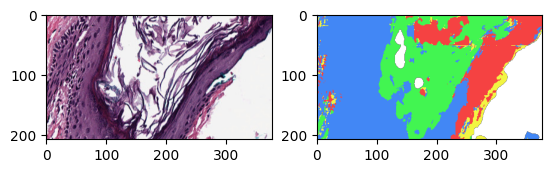

In [6]:
# We can pass the id of the slide directly to the get method
slide = children[0]
# or we can use File.get(api, id="<ID>") if we know the id
dzi_pyramid = DZIPyramid(slide.dzi_file)

# We can also get all annotations (currently rectangles and polygons supported) marked on the slide
print("Annotations:")
for annotation in slide.list_annotations():
    print(f"#{annotation.number}: {annotation.author}")
    print("Comments:", annotation.comments)
    print("Shape type:", annotation.shape_type)
    print()

print("Rectangle and polygon annotations:")
for annotation in slide.list_annotations_of_shape([ShapeType.RECT, ShapeType.POLYGON]):
    print(f"#{annotation.number}: {annotation.author}")
    print("Shape type:", annotation.shape_type)
    print()

# You can download the image from a selected annotation at a desired scale.
annotation = slide.list_annotations()[0]
scale = dzi_pyramid.get_scale_for(magnification=10)

region = annotation.as_shape().scale(scale)
if not isinstance(region, Rectangle):
    region = region.rotated_bounding_box()
image = dzi_pyramid.crop_rect(region, scale=scale)

plt.subplot(1, 2, 1)
plt.imshow(image)

mask = slide.list_tiled_masks()[0]
mask_pyramid = slide.get_tiled_mask_pyramid(mask)
scale = mask_pyramid.get_scale_for(magnification=10)
mask_image = mask_pyramid.crop_rect(region, scale=scale, allow_out_of_bounds=True)

plt.subplot(1, 2, 2)
plt.imshow(mask_image)

plt.show()

In [7]:
# Downloading original file
slide = children[0]

# The first argument is the directory path where the file will be saved. The file name is
# equal to the name of the original file which was uploaded
# add verbose=False, to disable printing progress bar
file_path = slide.download_original(".")
file_path

Downloaded file to ./test.svs


In [8]:
slide = children[0]
annotations = slide.list_annotations()
    
# change annotation label visibility
annot = annotations[0]
print(f"Current label visibility: {annot.is_label_visible}")
annot.change_label_visibility(api, is_visible=not annot.is_label_visible)
print(f"New label visibility: {annot.is_label_visible}")

Current label visibility: False
New label visibility: True


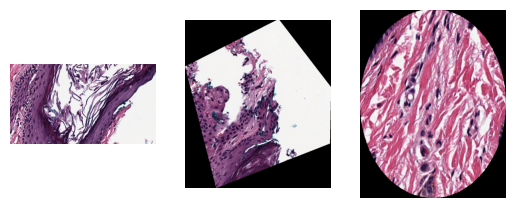

In [9]:
import matplotlib.pyplot as plt
import math

slide = children[0]
dzi_pyramid = DZIPyramid(slide.dzi_file)

annotations = list(slide.list_annotations_of_shape([
    ShapeType.RECT,
    ShapeType.POLYGON,
    ShapeType.CIRCLE,
    ShapeType.ELLIPSE
]))
num_annotations = len(annotations)

plt.figure()

for i, annotation in enumerate(annotations):
    region = annotation.as_shape()
    # default fill value is 255 (white), but we set it to 0 (black) for better visibility
    image = dzi_pyramid.crop_shape(region, fill_value=0)
    plt.subplot(math.ceil(num_annotations / 3), 3, i+1)
    plt.imshow(image)
    plt.axis("off")

plt.show()

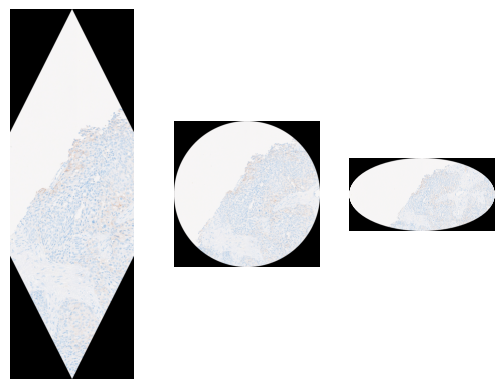

In [ ]:
# You can also crop shapes from the image pyramid directly

slide = children[0]
dzi_pyramid = DZIPyramid(slide.dzi_file)

plt.figure()

polygon = Polygon([(2000, 2000), (2500, 1000), (3000, 2000), (3000, 3000), (2500, 4000), (2000, 3000)])
image = dzi_pyramid.crop_shape(polygon, fill_value=0)
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis('off')

circle = Circle((2500, 2500), 1000)
image = dzi_pyramid.crop_shape(circle, fill_value=0)
plt.subplot(1, 3, 2)
plt.imshow(image)
plt.axis('off')

ellipse = Ellipse((2500, 2500), (2000, 1000))
image = dzi_pyramid.crop_shape(ellipse, fill_value=0)
plt.subplot(1, 3, 3)
plt.imshow(image)
plt.axis('off')

plt.show()
